In [13]:
# Library to handle data
import pandas as pd

# Library to connect with Google servers and use BigQuery
from pyfrost import BigQuery

# Library to create a logger
import logging
logging.basicConfig(  # Defining logger formatation
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [4]:
# Creating client variable
client = BigQuery()

In [5]:
# Downloading train and test tables from kaggle database
train = client.download('kaggle.train')
test = client.download('kaggle.test').drop('Predicted', axis=1)

In [6]:
# Printing table info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 4 columns):
session_date    99362 non-null object
ticker          99362 non-null object
Id              99362 non-null object
up_5p           99362 non-null int64
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [7]:
# Describing dates for training
max_day = train['session_date'].unique().max()
min_day = train['session_date'].unique().min()
print("""Training set\n
Max date:\t\t{}\nMin date:\t\t{}\nTotal days in a row:\t{}
""".format(max_day,min_day,max_day-min_day))

Training set

Max date:		2018-05-16
Min date:		2017-07-19
Total days in a row:	301 days, 0:00:00



In [8]:
# Describing dates for testing
max_day = test['session_date'].unique().max()
min_day = test['session_date'].unique().min()
print("""Testing set\n
Max date:\t\t{}\nMin date:\t\t{}\nTotal days in a row:\t{}
""".format(max_day,min_day,max_day-min_day))

Testing set

Max date:		2019-02-07
Min date:		2018-06-08
Total days in a row:	244 days, 0:00:00



# Data Preparation - Merge with Stock Prices Table

As a good-practice rule, the user should have the habit to create a table in **his/her database with** the particular query and **download** it later with no cost.

In [ ]:
# Creating the table with the particular query
_ = client.query('''
CREATE TABLE 
    guipjfranze.stock_trade_kaggle_test
AS
    SELECT  ticker,
            session_date,
            high,low,
            open,
            close,
            median,
            mean,
            volume,
            vwap
    FROM b3.stock_time_bars
    WHERE session_date > DATE '2017-07-19'
    AND period = '1 day';
''')

In [9]:
# Downloading the table with no cost
stock_trade = client.download('guipjfranze.stock_trade_kaggle_test')

In [10]:
# Merging table with train table
train_rich = pd.merge(train, stock_trade, on=['ticker','session_date'])

In [11]:
# Printing the head
train_rich.head()

session_date  ticker               Id  up_5p   high    low   open  close  \
0   2017-07-20   AALR3   AALR3_20170720      1  17.79  17.52  17.73  17.55   
1   2017-07-20  AAPL34  AAPL34_20170720      0  47.46  47.35  47.35  47.46   
2   2017-07-20   ABCB2   ABCB2_20170720      1   3.42   3.11   3.42   3.15   
3   2017-07-20   ABCB4   ABCB4_20170720      0  17.01  16.58  16.71  16.65   
4   2017-07-20  ABCP11  ABCP11_20170720      0   16.5  16.45   16.5  16.49   

  median          mean    volume          vwap  
0   17.6  17.601740614   1348562  17.582294654  
1  47.35  47.386666667     90009  47.373157895  
2   3.17   3.182727273     22193   3.170428571  
3  16.71     16.744325   2015220  16.723817427  
4  16.49        16.492  17303.78  16.495500477

# Visualizing Data in Cadlestick Plot

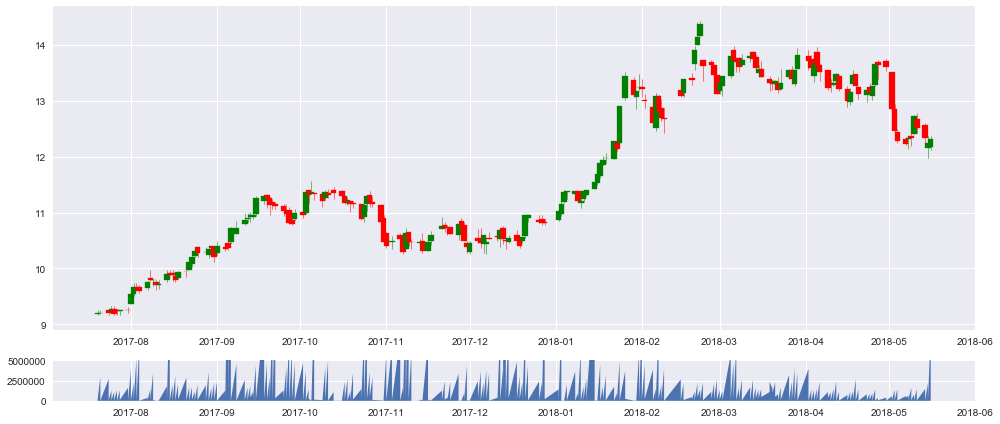

In [17]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
%matplotlib inline
from mpl_finance import candlestick_ohlc

# Mapping the data to seconds in order to fit 
# the Matpotlib format
train_rich['session_date'] = train_rich['session_date'].apply(mdates.date2num)

# Creating new figures
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1, fig=fig)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, fig=fig, sharex=ax1)
ax1.xaxis_date()

X_data = train_rich.loc[train_rich['ticker']=='ITSA4'][['session_date',
                                                        'open',
                                                        'high',
                                                        'low',
                                                        'close']]

candlestick_ohlc(ax1, X_data.values, width=2, colorup='g')
ax2.fill_between(train_rich['session_date'].values,
                 train_rich['volume'].astype(int).values, y2=0,linestyle='-')
ax2.set_ylim(0,5e6)

plt.tight_layout()
plt.show()